# Image processing and nuclear segmentation and image quantification

This notebook demonstrates how to perform image segmentation and quantification on fluorescence microscopy data. We'll work with a two-channel image dataset from the Broad Institute's BBBC013 collection.

## Setup and Data Loading
First, we import the required libraries and mount Google Drive to access our data




In [ ]:

#Mounting drive gives Google Colab access to your Google drive files. Authorize all steps
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Install this library if not using Google Colab
!pip install napari_segment_blobs_and_things_with_membranes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops_table, label, find_contours
from skimage.io import imread, imsave
from skimage import filters, color
from skimage.filters import gaussian
import pandas as pd
import os
import matplotlib.colors as mcolors



## The images that we will be using comes from https://bbbc.broadinstitute.org/BBBC013

In [ ]:
#Add your folder path ('folder/path') in the code
os.chdir('/content/drive/MyDrive/Colab Notebooks/curso_bioimagem_fev_2025/BBBC013_v1_images_bmp/BBBC013_tiff')

## Data Loading and Visualization

We'll work with two-channel fluorescence microscopy images:
- Channel 1: FKHR-EGFP, a probe for PI3k/AKT signaling
- Channel 2: DRAQ, a DNA stain

Let's load and visualize both channels separately and then create a merged view.

In [ ]:
channel1 = imread('Channel1-01-A-01.tiff')
channel2 = imread('Channel2-01-A-01.tiff')

In [ ]:
channel1.shape

In [ ]:
plt.imshow(channel1, cmap = 'gray')

In [ ]:
plt.imshow(channel2, cmap = 'gray')

In [ ]:


# Define custom colormaps cyan_cmap and magenta_cmap
red = mcolors.LinearSegmentedColormap.from_list("", ["black", "red"])
green = mcolors.LinearSegmentedColormap.from_list("", ["black", "green"])

# Create the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot the channel 1 image (full image)
axs[0].imshow(channel1, cmap=red)
axs[0].axis('off')
axs[0].set_title('Channel 1', fontsize=16)

# Plot the channel 2 image (full image)
axs[1].imshow(channel2, cmap=green)
axs[1].axis('off')
axs[1].set_title('Channel 2', fontsize=16)

# Create and plot the merged visualization (full image)
merged = np.stack(
    [
        channel1 / channel1.max(),  # Normalize channel 1
        channel2 / channel2.max(),  # Normalize channel 2
        np.zeros_like(channel1),  # Blue channel (empty)
    ],
    axis=-1,
)
axs[2].imshow(merged)
axs[2].axis('off')
axs[2].set_title('Merged', fontsize=16)




## Image Segmentation

Image segmentation is the process of dividing a digital image into multiple distinct **regions** or segments, where each segment shares similar characteristics (like color, intensity, or texture). The goal is to simplify the image representation and make it easier to analyze by separating objects of interest from the background and from each other. In biomedical imaging, this often means identifying individual cells, organelles, or tissues within microscopy images.

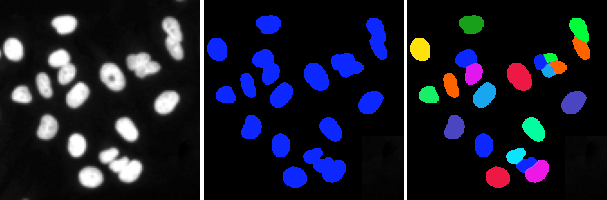

Link for the image source and a good and concise material on cell segmentation: https://www.nicolaromano.net/data-thoughts/segmentation/


**We'll testing different classical threshold methods to segment cell nuclei from the background**

In [ ]:
filters.try_all_threshold(channel2, figsize = (10,
                                  10))

In [ ]:
#try filters to process the image

In [ ]:
threshold = filters.threshold_otsu(channel2)

In [ ]:
mask  = channel2 > threshold

In [ ]:
plt.imshow(mask, cmap='gray')
plt.axis("off")

In [ ]:
label_image = label(mask)

In [ ]:
# Convert the label image to an RGB image for visualization
label_image_original = color.label2rgb(label_image, image=channel2, bg_label=0, alpha=0.3)

# Display the label image
plt.figure(figsize=(8, 8))
plt.imshow(label_image_original)
plt.title("Original  and Label Image Merged")
plt.axis("off")
plt.show()


In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(channel2, cmap= 'gray')
plt.title("Contours of Labels on Original Image")

# Find and overlay contours
for region in range(1, label_image.max() + 1):  # Skip background (label 0)
    contours = find_contours(label_image == region, level=0.5)
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=0.5)

# Remove axis for cleaner display
plt.axis("off")
plt.show()

# Pre segmentaion image processing

To improve our segmentation results, we'll:
1. Apply Gaussian filtering to reduce noise
2. Separate touching objects using watershed segmentation
3. Compare results between different processing steps

In [ ]:
#1. Apply Gaussian filtering to reduce noise
channel2_gaussian = gaussian(channel2, sigma=2)



In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(channel2, cmap='gray')
axs[0].set_title('original image')
axs[1].imshow(channel2_gaussian, cmap='gray')
axs[1].set_title(' filtered image')

Now it is your turn to write code to perform segmentation in the processed (Gaussian filtered) image.
Compare segmentation side by side performed on the original and processed image

In [ ]:
#Write your code here

In [ ]:
#2. Separate touching objects using watershed segmentation. This is a type of Binary Mask Processing
from napari_segment_blobs_and_things_with_membranes import split_touching_objects
mask_split_objects = split_touching_objects(mask)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,15))
axs[0].imshow(mask, cmap='gray')
axs[1].imshow(mask_split_objects, cmap='gray')

Now it is your turn to write code to perform segmentation in the binary and post-processed image.
Compare segmentation side by side of all the original, processed, processed + binary mask processed.


In [ ]:
#write your code here

## Quantitative Analysis

After segmentation, we can extract various measurements from our identified objects using `regionprops`. This allows us to:
- Measure basic morphological features
- Calculate intensity values
- Export results for further analysis

In [ ]:
regions = regionprops_table(label_image=label_image, intensity_image=channel1, properties =('label','area','mean_intensity'))

In [ ]:
#the output is a dictionary
regions

Regionprops_tables contains other properties besides 'area' and 'mean_instensity'. Search on the internet for skimage regionprops_table documentation and add extra properties in the code. Run the code

In [ ]:
#write your code here

In [ ]:
#check the first 15 rows of the dataframe
df.head(15)


In [ ]:
#try now yourself a code to check the dataframe tail

## Data Visualization and Statistical Analysis

Now that we have our measurements, let's:
1. Learn to handle data with dataframes
2. Calculate basic statistics
3. Create visualizations to understand our data distribution




## Dataframes

Pandas DataFrames are the primary tool in  Python for handling tabular data. Its primary object, the “DataFrame” is extremely useful in wrangling data.
[Check out a brief introduction on dataframe](https://biapol.github.io/Quantitative_Bio_Image_Analysis_with_Python_2022/day3a_Tabular_Data_and_Descriptive_Statistics/01_introduction_dataframes.html)


In [ ]:
# This convert the dictionary into a dataframe (a type of tabular representation of the data).
# We commonly name a dataframe as df or df_something.
df = pd.DataFrame(regions)

In [ ]:
#save dataframe as .csv (comma separated values), a spreadsheet document readable in lots of software including Excel.
df.to_csv('df_resultsday1.csv', index='False')

In [ ]:
#check if your .csv file is the folder
!ls

Test you capacity to learn coding from the package documentation.

Your goal now is to read a .csv file in Python and obtain the mean, median and describe statistics using the package Pandas. See the package documentation for basic stats [here](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html)  

In [ ]:
#Write your code here

Let's do some plotting

In [ ]:

plt.hist(df['area']) # this single line of code prints a histogram plot
plt.xlabel('nuclear area') # this adds a label for the x axis
plt.ylabel('count') # this adds a label for the y axis
plt.title('area distribution.') # this adds a title for the plot

Now, it is your turn to play around with plots.
1. Plot a histogram for mean_intensity
2. Plot a scatter plot of mean_intensity versus area
3. Try to change the plot colors and font sizes (search the internet and please do not use AI chat bots for it now)

In [ ]:
#write your code here

In [ ]:
#write your code here